# EDA — Workshop ETL

In [ ]:

import pandas as pd
from pathlib import Path

RAW = Path("../data/raw")
tx = pd.read_csv(RAW/"transactions.csv")
cu = pd.read_csv(RAW/"customers.csv")
pr = pd.read_csv(RAW/"products.csv")
fx = pd.read_csv(RAW/"exchange_rates.csv")
cr = pd.read_csv(RAW/"country_region.csv")
tx.head()


## TODO: perfilado, monedas, clientes, productos, temporal

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

plt.style.use("seaborn-v0_8-whitegrid")
sns.set_palette("viridis")


DATA = Path("../data/output")

fact = pd.read_csv(DATA / "fact_transactions.csv")
daily = pd.read_csv(DATA / "agg_daily.csv")

print("✅ Archivos cargados correctamente:")
print(f"fact_transactions: {fact.shape}")
print(f"agg_daily: {daily.shape}")
fact.head()

✅ Archivos cargados correctamente:
fact_transactions: (21740, 13)
agg_daily: (8078, 6)


,txn_id,customer_id,product_id,ts,date,month,country,region,category,status,currency,amount,amount_usd
0,t0009825,c03290,p0063,2025-01-01 00:49:00+00:00,2025-01-01,2025-01,PE,LATAM,toys,refunded,USD,9.16,9.160
1,t0014946,c03486,p0008,2025-01-01 02:26:00+00:00,2025-01-01,2025-01,CA,NaN,toys,refunded,EUR,27.35,29.538
2,t0014336,c01089,p0031,2025-01-01 02:55:00+00:00,2025-01-01,2025-01,ES,EU,home,paid,USD,35.37,35.370
3,t0016341,c01132,p0115,2025-01-01 04:39:00+00:00,2025-01-01,2025-01,IT,EU,home,paid,USD,44.48,44.480
4,t0005937,c01213,p0023,2025-01-01 07:04:00+00:00,2025-01-01,2025-01,CA,NaN,books,paid,USD,12.19,12.190


🧩 Nulos por columna:


region     7477
country     625
dtype: int64

🔁 Duplicados por txn_id: 0


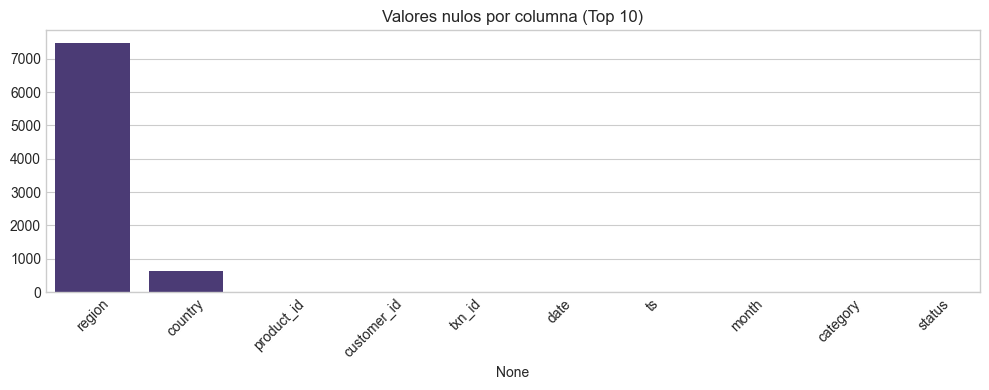

❗ Registros con fecha inválida: 0


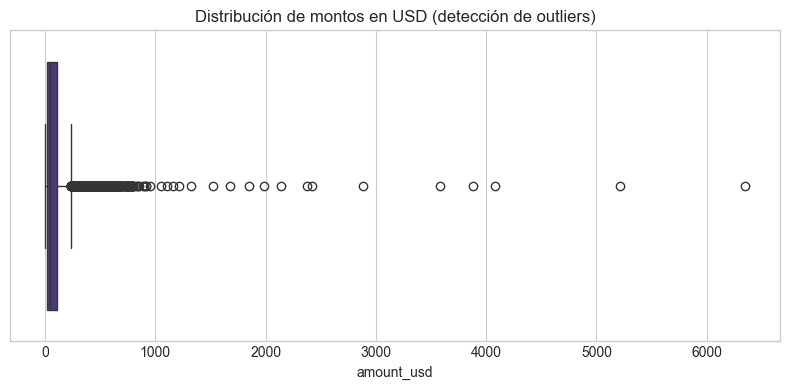

In [ ]:

# --- Nulos y duplicados
nulls = fact.isna().sum().sort_values(ascending=False)
dups = fact.duplicated(subset=["txn_id"]).sum()

print("🧩 Nulos por columna:")
display(nulls[nulls > 0])
print(f"🔁 Duplicados por txn_id: {dups}")

plt.figure(figsize=(10,4))
sns.barplot(x=nulls.head(10).index, y=nulls.head(10).values)
plt.title("Valores nulos por columna (Top 10)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# --- Fechas inválidas
fact["_ts_parsed"] = pd.to_datetime(fact["ts"], errors="coerce")
invalid_dates = fact[fact["_ts_parsed"].isna()]
print(f"❗ Registros con fecha inválida: {len(invalid_dates)}")

# --- Outliers (montos USD)
plt.figure(figsize=(8,4))
sns.boxplot(x=fact["amount_usd"])
plt.title("Distribución de montos en USD (detección de outliers)")
plt.tight_layout()
plt.show()

C:\Users\USER\AppData\Local\Temp\ipykernel_24676\4189949553.py:6: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  fact["_month"] = pd.to_datetime(fact["ts"], errors="coerce").dt.to_period("M").astype(str)


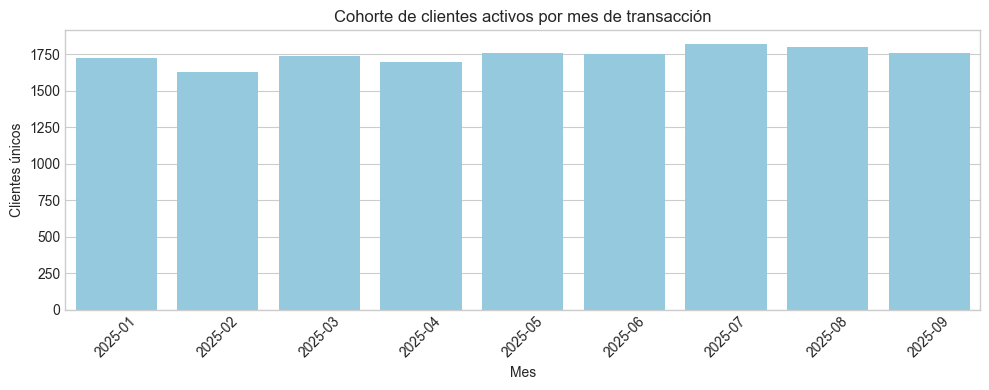

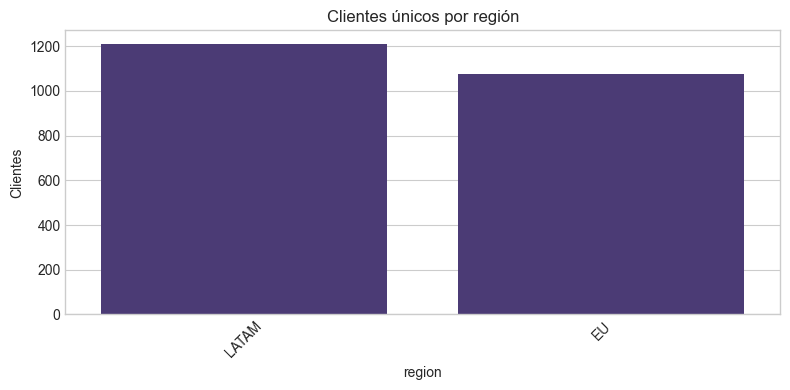

In [ ]:

# --- Cohortes mensuales basadas en transacciones (no signup)
fact["_month"] = pd.to_datetime(fact["ts"], errors="coerce").dt.to_period("M").astype(str)
cohort = fact.groupby("_month")["customer_id"].nunique().reset_index(name="clientes_activos")

plt.figure(figsize=(10,4))
sns.barplot(data=cohort, x="_month", y="clientes_activos", color="skyblue")
plt.title("Cohorte de clientes activos por mes de transacción")
plt.xlabel("Mes")
plt.ylabel("Clientes únicos")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# --- Distribución de clientes por región
region_clientes = fact.groupby("region")["customer_id"].nunique().sort_values(ascending=False)
plt.figure(figsize=(8,4))
sns.barplot(x=region_clientes.index, y=region_clientes.values)
plt.title("Clientes únicos por región")
plt.ylabel("Clientes")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

,category,count,mean,std,min,max
0,beauty,3222,39.800137,59.163770,0.51040,1982.8800
1,books,3736,19.795639,18.597154,0.30624,489.4200
2,clothing,2801,52.377702,86.323765,0.92452,3884.6628
3,electronics,5912,206.178872,194.704121,3.57860,6346.6400
4,home,2628,63.781315,99.831223,0.75226,4076.8000
5,sports,1642,67.674863,52.707651,0.98020,394.0164
6,toys,1799,26.249301,22.058259,0.38048,363.2500


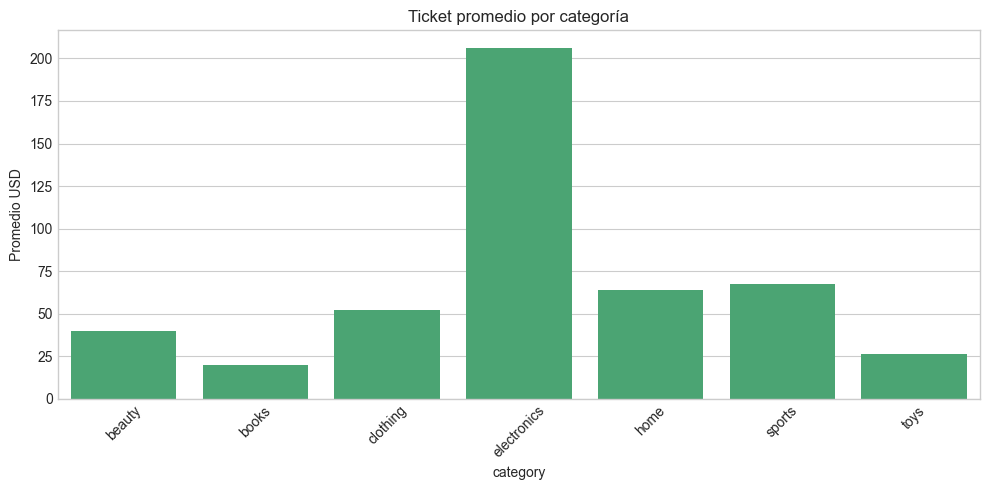

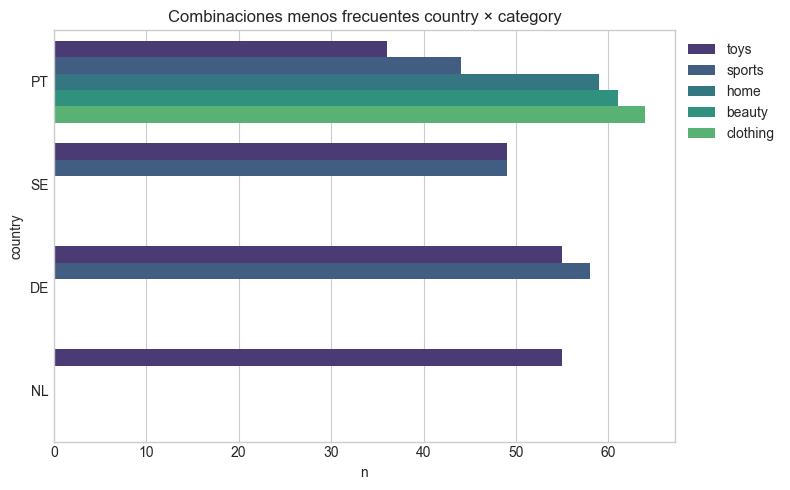

In [ ]:

# --- Ticket promedio y dispersión
ticket = (
    fact.groupby("category")["amount_usd"]
    .agg(["count","mean","std","min","max"])
    .reset_index()
)
display(ticket)

plt.figure(figsize=(10,5))
sns.barplot(data=ticket, x="category", y="mean", color="mediumseagreen")
plt.title("Ticket promedio por categoría")
plt.xticks(rotation=45)
plt.ylabel("Promedio USD")
plt.tight_layout()
plt.show()

# --- Combinaciones anómalas country × category
combo = fact.groupby(["country","category"]).size().reset_index(name="n")
rare = combo.sort_values("n").head(10)
plt.figure(figsize=(8,5))
sns.barplot(data=rare, x="n", y="country", hue="category")
plt.title("Combinaciones menos frecuentes country × category")
plt.legend(bbox_to_anchor=(1,1))
plt.tight_layout()
plt.show()

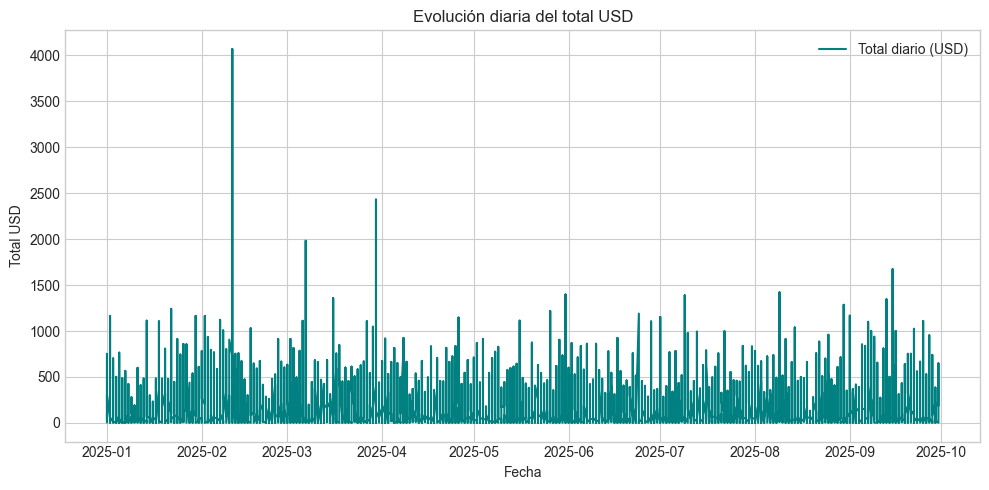

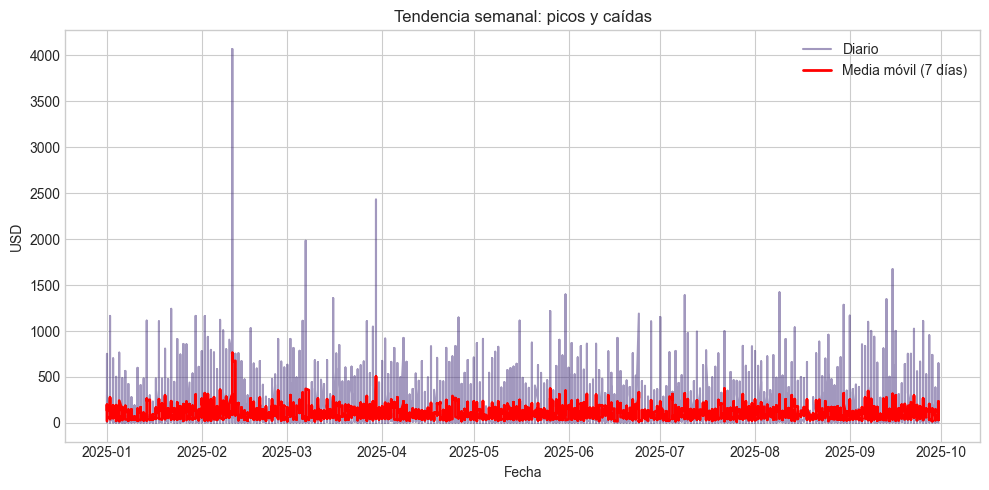

In [ ]:

daily["date"] = pd.to_datetime(daily["date"], errors="coerce")
daily = daily.sort_values("date")

plt.figure(figsize=(10,5))
plt.plot(daily["date"], daily["total_usd"], label="Total diario (USD)", color="teal")
plt.title("Evolución diaria del total USD")
plt.xlabel("Fecha")
plt.ylabel("Total USD")
plt.legend()
plt.tight_layout()
plt.show()

# --- Media móvil semanal
daily["rolling7"] = daily["total_usd"].rolling(7, min_periods=1).mean()

plt.figure(figsize=(10,5))
plt.plot(daily["date"], daily["total_usd"], alpha=0.5, label="Diario")
plt.plot(daily["date"], daily["rolling7"], color="red", linewidth=2, label="Media móvil (7 días)")
plt.title("Tendencia semanal: picos y caídas")
plt.xlabel("Fecha")
plt.ylabel("USD")
plt.legend()
plt.tight_layout()
plt.show()